In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from example import get_TurnPoint, bottomUp, merge_cost
import math
import numpy.linalg as LA

_数据格式_
```
+ 0 0 2 tcp 40 ------- 1 0.0 3.0 0 0
```
1. 动作: “+”：Enqueue；“-”：Dequeue；“r”：Receive；"d"：Drop
2. 时间
3. from_node
4. to_node
5. 封包的类型
6. 封包的大小（单位byte）
7. 标记标注
8. 属于哪个数据流
9. 来源端
10. 目的端
11. sequence number
12. ID

ref: https://blog.csdn.net/yhdyy123/article/details/74027683


In [2]:
file_path = "trace/newreno/5/newreno.tr"

def load_ack(path):
    with open(path, 'r') as f:
        file_lines = f.readlines()
    ack_seq=[]  #提取含字段 r 2 0的ack帧    
    for line in file_lines:
        line = line.strip().split()
        if line[4] != "ack" or line[2] != '2' or line[3] != '0':
            continue
        ack_seq.append([line[0], float(line[1]), int(line[10])])
        
    return ack_seq

def load_tcp(path):
    with open(path, 'r') as f:
        file_lines = f.readlines()
    tcp_seq=[]  #提取含字段 r 2 0的ack帧    
    for line in file_lines:
        line = line.strip().split()
        if line[4] != "tcp" or line[2] != '0' or line[3] != '2':
            continue
        tcp_seq.append([line[0], float(line[1]), int(line[10])])
        
    return tcp_seq

def load_cwd(path):
    with open(path, 'r') as f:
        file_lines = f.readlines()
    cwd_seq=[]  #提取含字段 r 2 0的ack帧    
    for i in range(len(file_lines)):
        line = file_lines[i]
        line = line.strip().split()
        if line[5] != "cwnd_":
            continue
        cwd_seq.append([float(line[0]), float(line[6])])
        
    return cwd_seq

ack_seq = load_ack(file_path)
tcp_seq = load_tcp(file_path)
cwd_seq = load_cwd(file_path)
cwd_seq[0:5]

[[0.0, 1.0], [0.1281, 2.0], [0.25792, 3.0], [0.2591, 4.0], [0.38774, 5.0]]

In [93]:
def get_tcp_enqueue(tcp_seq):
    tcp_enqueue_seq = []
    for item in tcp_seq:
        if item[0] != '+':
            continue
        tcp_enqueue_seq.append([item[1], item[2]])
    return np.array(tcp_enqueue_seq)

def get_ack_receive(ack_seq):
    ack_receive_seq = []
    for item in ack_seq:
        if item[0] != 'r':
            continue
        ack_receive_seq.append([item[1], item[2]])
    return np.array(ack_receive_seq)

tcp_enqueue_seq = get_tcp_enqueue(tcp_seq)
ack_receive_seq = get_ack_receive(ack_seq)
print(len(tcp_enqueue_seq), len(ack_receive_seq))

83071 82558


In [4]:
def draw_plot(data1, label1, data2=None, label2=None, plot_title="Plot", save_fig=False):
    fig = plt.figure(figsize=(16,6))
    plt.plot(data1[:,0],data1[:,1],alpha=0.8,color='red',label=label1)
    if data2 is not None:
        plt.plot(data2[:,0],data2[:,1],alpha=0.8,color='blue',label=label2)
    plt.title(plot_title)
    plt.legend(loc='best')
    plt.xlabel("time")
    plt.ylabel("sequence number")
    plt.show()
    if save_fig:
        plt.savefig(plot_title+'.png')


In [89]:
save_path = "test/newreno"
if not os.path.exists(save_path):
    os.makedirs(save_path)
np.savetxt(os.path.join(save_path,'tcp_enqueue_seq.txt'), np.asarray(tcp_enqueue_seq),fmt='%.8f %.6f')
np.savetxt(os.path.join(save_path,'ack_receive_seq.txt'), np.asarray(ack_receive_seq),fmt='%.8f %.6f')

In [51]:
def find_retr(cwd_seq, tcp_enqueue_seq, time_range=0.25):
    retr_seq = []
    pre = cwd_seq[0]
    idx = 0
    for i in range(len(cwd_seq)):
        if pre[1] > cwd_seq[i][1]: #降窗
            tm = round(cwd_seq[i][0],3)
            print(tm)
            tmp_seq = []
            while idx < len(tcp_enqueue_seq):
                if tcp_enqueue_seq[idx][0] > tm - time_range and tcp_enqueue_seq[idx][0] < tm + time_range:
                    tmp_seq.append([tcp_enqueue_seq[idx][0], tcp_enqueue_seq[idx][1]])
                elif tcp_enqueue_seq[idx][0] > tm + time_range:
                    break
                idx += 1
            tmp_seq=np.array(tmp_seq)
            retr_seq.append(tmp_seq)
        pre = cwd_seq[i]
    return  retr_seq

retr_seq = find_retr(cwd_seq, tcp_enqueue_seq)

(421, 2)


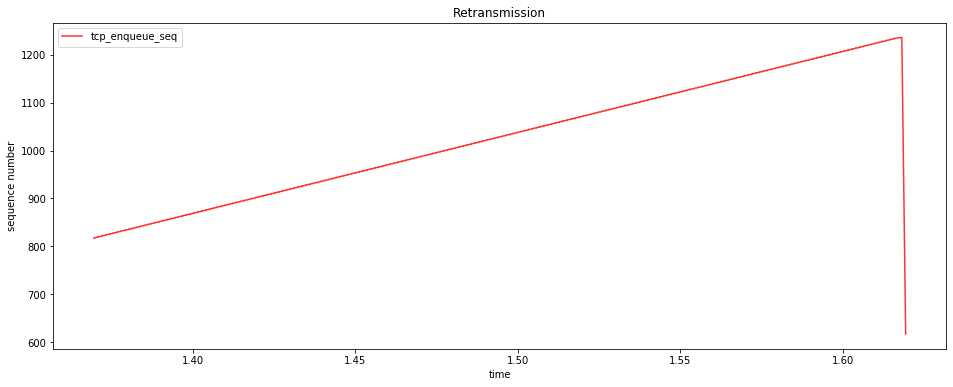

In [55]:
for item in retr_seq:
    print(item.shape)
    draw_plot(item, "tcp_enqueue_seq", plot_title="Retransmission")
    break

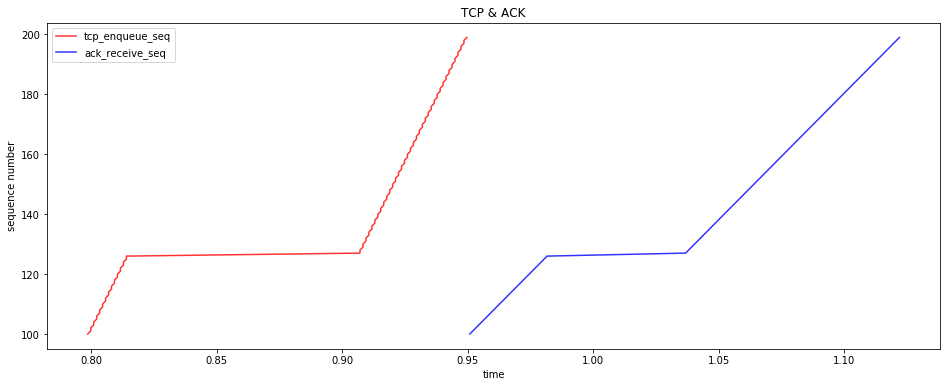

In [64]:
draw_plot(tcp_enqueue_seq[100:200], "tcp_enqueue_seq", ack_receive_seq[100:200], "ack_receive_seq", plot_title="TCP & ACK")

In [103]:
def cal_rtt(tcp_enqueue_seq, ack_receive_seq): #计算rtt
    '''
    :return rtt_list: 元素格式 [seq_num, rtt, tcp_time, ack_time]
    '''
    arr_list = [tcp_enqueue_seq, ack_receive_seq]
    dict_list = []
    for arr in arr_list:
        dict = {}
        for row in arr:
            index = row[1]
            time = row[0]
            if index not in dict:
                dict[index] = []
            dict[index].append(time)
        dict_list.append(dict)
    rtt_list = []
    for index in dict_list[0]:
        if index in dict_list[1]:
            times1 = dict_list[0][index]
            times2 =dict_list[1][index]
            for i in range(min(len(times1), len(times2))):
                rtt_list.append([index, abs(times1[i] - times2[i]), times1[i], times2[i]])
    return rtt_list
rtt_list = cal_rtt(tcp_enqueue_seq, ack_receive_seq)
rtt_list[0:5]

[[0.0, 0.128096, 0.0, 0.128096],
 [1.0, 0.129824, 0.128096, 0.25792],
 [2.0, 0.131008, 0.128096, 0.259104],
 [3.0, 0.129824, 0.25792, 0.387744],
 [4.0, 0.131008, 0.25792, 0.388928]]

In [108]:
def cal_cap(tcp_enqueue_seq, ack_receive_seq): #计算容量
    '''
    :return cap_list: 元素格式 [time, cap]
    '''
    cap_list = []
    dict1 = {k: v for k, v in tcp_enqueue_seq}
    dict2 = {k: v for k, v in ack_receive_seq}
    for k in dict1:
        if k in dict2:
            cap_list.append([k, abs(dict1[k] - dict2[k])])
    return cap_list
cap_list = cal_cap(tcp_enqueue_seq, ack_receive_seq)
cap_list[0:5]

[[0.128096, 2.0],
 [0.25792, 3.0],
 [0.259104, 4.0],
 [0.387744, 5.0],
 [0.388928, 6.0]]

In [173]:
def get_TurnPoint(data, angle_thred):
    ''' 
    :paras data:时间序列数据
    :paras angle_thred: 判定其是否为转折点的角度阈值
 
    :return turnPoints: 预选的转折点
    '''
    turnPoints = []
    for index in range(1, len(data)-1):
        # 这里存在一个隐性的 时间序列采样是否均匀 的问题 
        # 这里如果时间采样不均匀，记得将 atan() 中的数据除以对应时间差
        theta1 = math.atan((data[index][1] - data[index - 1][1])/(data[index][0] - data[index - 1][0])) * (180 / math.pi)
        theta2 = math.atan((data[index + 1][1] - data[index][1])/(data[index + 1][0] - data[index][0])) * (180 / math.pi)
        if theta1 * theta2 < 0:
            alpha = abs(theta1) + abs(theta2)
        else:
            alpha = abs(theta1 - theta2)
        if alpha > angle_thred:
            turnPoints.append(index)
    turnPoints.insert(0, 0)
    turnPoints.append(len(data)-1)
    return turnPoints

def merge_cost(data, merge_start, merge_end):
    ''' 
    本方法使用 least-squares solution to a linear matrix equation 方法进行直线拟合。
    同时获得拟合误差。
    调用 numpy.linalg.lstsq() 方法
    :param data: 时间序列数据
    :param merge_start: 合并起始点
    :param merge_end: 合并终点
 
    :return error: 合并产生的误差
    '''
    x = np.array(data[merge_start:merge_end+1, 0])
    y = np.array(data[merge_start:merge_end+1, 1])
    A = np.ones((len(x), 2), np.float64)
    A[:,0] = x
    try:
        (result, residual, rank, s) = LA.lstsq(A, y, rcond=None) #回归系数、残差平方和、自变量X的秩、X的奇异值
        error = math.sqrt(residual[0])

    except np.linalg.LinAlgError:
        error = 0.0
    except IndexError:
        error = 0.0
 
    return error, result

def bottomUp(data, type_name, turn_points, error_thred, error_estimator=merge_cost):
    ''' 
    :param data: 时间序列数据
    :param turn_points: 转折点数据
    :param error_thred: 融合过程中的误差阈值, 超过阈值后, 融合停止
    :param error_estimator: 融合过程中的误差估计方法
 
    :return segments
    '''
    index = 0
    segments = [turn_points[0]] # 加入起始的开始点
    plr_data = [] # 插值成完整时间序列，方便后续比对
    len_turnPoints = len(turn_points) - 1
    cnt = 0
    while index < len_turnPoints:
        start = index
        end = index + 1
        error, ratio = error_estimator(data, turn_points[start], turn_points[end])
        while error < error_thred:
            end += 1
            if not (end < len_turnPoints): 
                end = len_turnPoints
                break
            error, ratio = error_estimator(data, turn_points[start], turn_points[end])
        segments.append(turn_points[end])
        x_range = data[turn_points[start]:turn_points[end], 0]
        pre_seq = data[turn_points[start]:turn_points[end], 1]
        tmp_data = np.c_[np.full((len(x_range,)), type_name), x_range, pre_seq, ratio[0]*x_range+ratio[1], np.full((len(x_range,)), cnt), np.full((len(x_range,)), ratio[0])]
        plr_data.extend(tmp_data.tolist())
        index = end
        cnt += 1
        last_ratio = ratio[0]
    plr_data.append([type_name, data[-1][0], data[-1][1], data[-1][1], last_ratio, cnt])
    return segments, plr_data

def plr(raw_data, type_name, angle_thred=0.1, error_thred=1e-3):
    ''' 
    :param angle_thred: 判定其是否为转折点的角度阈值
    :param error_thred: 融合过程中的误差阈值, 超过阈值后, 融合停止
 
    :return segments: 分割点序列
    :return plr_data: 线性插值补充后的序列（与原数据维度一致，方便进行对比）
    '''
    turn_points = get_TurnPoint(raw_data, angle_thred)
    segments, plr_data = bottomUp(raw_data, type_name, turn_points, error_thred, merge_cost) 
    draw_plot(raw_data, "raw_data", raw_data[segments], "segments", "RawData & Segments with {}_{}".format(angle_thred, error_thred))
    save_path = "test/newreno"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.savetxt(os.path.join(save_path,'{}__plrdata_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(plr_data),fmt='%s %s %s %s %s %s')
    #转换的时候因为第一列加了str类型，后面也全变str了..，读的时候记得转换
    #np.savetxt(os.path.join(save_path,'{}__plrdata_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(plr_data),fmt='%d %.8f %d %.6f %d %.6f')
    np.savetxt(os.path.join(save_path,'{}_segments_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(raw_data[segments]),fmt='%.8f %.6f')
    return segments, plr_data

In [ ]:

def get_ack_inputs(raw_data, type_name="ack", angle_thred=0.1, error_thred=1e-3):
    ''' 
    :param raw_data: ack_receive_seq
    :param angle_thred: 判定其是否为转折点的角度阈值
    :param angle_thred: 判定其是否为转折点的角度阈值
    :param error_thred: 融合过程中的误差阈值, 超过阈值后, 融合停止
 
    :ack_segments.txt: 分割点[time, seq] 构成的数据集
    :ack_inputs.txt: 插值后 [type, time, seq, plr_seq, 分段相对位置, 斜率] 构成的数据集
    '''
    turn_points = get_TurnPoint(raw_data, angle_thred)
    segments, plr_data = bottomUp(raw_data, type_name, turn_points, error_thred, merge_cost) 
    draw_plot(raw_data, "raw_data", raw_data[segments], "segments", "RawData & Segments with {}_{}".format(angle_thred, error_thred))
    save_path = "test/newreno"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.savetxt(os.path.join(save_path,'{}_inputs_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(plr_data),fmt='%s %s %s %s %s %s')
    #转换的时候因为第一列加了str类型，后面也全变str了..，读的时候记得转换
    #np.savetxt(os.path.join(save_path,'{}__plrdata_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(plr_data),fmt='%d %.8f %d %.6f %d %.6f')
    np.savetxt(os.path.join(save_path,'{}_segments_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(raw_data[segments]),fmt='%.8f %.6f')
    return

get_ack_inputs(ack_receive_seq)

e:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
e:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


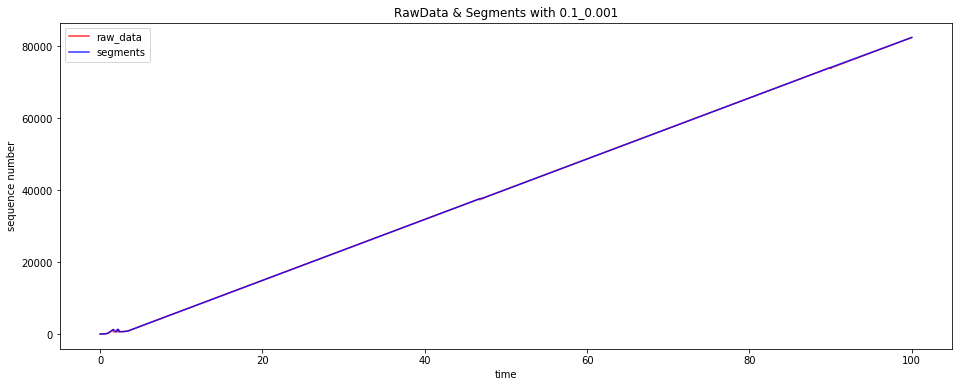

In [175]:
def get_seq_input(tcp_enqueue_seq):
    ''' 
    :param raw_data: get_receive_seq
    :param angle_thred: 判定其是否为转折点的角度阈值
    :param angle_thred: 判定其是否为转折点的角度阈值
    :param error_thred: 融合过程中的误差阈值, 超过阈值后, 融合停止
 
    :seq_segments.txt: tcp_enqueue_seq中的分割点 [time, seq] 构成的数据集
    :seq_inputs.txt: 插值后 [type, time, seq, plr_seq, 分段相对位置, 斜率, 网络容量, rtt] 构成的数据集
    '''
    turn_points = get_TurnPoint(raw_data, angle_thred)
    segments, plr_data = bottomUp(raw_data, type_name, turn_points, error_thred, merge_cost) 
    draw_plot(raw_data, "raw_data", raw_data[segments], "segments", "RawData & Segments with {}_{}".format(angle_thred, error_thred))
    save_path = "test/newreno"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.savetxt(os.path.join(save_path,'{}_inputs_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(plr_data),fmt='%s %s %s %s %s %s')
    #转换的时候因为第一列加了str类型，后面也全变str了..，读的时候记得转换
    #np.savetxt(os.path.join(save_path,'{}__plrdata_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(plr_data),fmt='%d %.8f %d %.6f %d %.6f')
    np.savetxt(os.path.join(save_path,'{}_segments_{}_{}.txt'.format(type_name, angle_thred, error_thred)), np.asarray(raw_data[segments]),fmt='%.8f %.6f')
    return

def get_reseq_input(tcp_enqueue_seq):
    